# Interactive inference

In [16]:
from models.single_policy import SinglePolicy
from single_agent import SingleAgent
from IPython.display import SVG, display, HTML
import torch
from torch import distributions
import pdb
import vh_graph
import gym
import envdataset
import utils_viz
import utils
import sys
from IPython.display import Image
sys.argv = ['-f'] 

In [17]:
curr_env = gym.make('vh_graph-v0')

In [18]:
ls

belief_example.gv.pdf  Digraph.gv.png               README.md
dataset/               envdataset.py                single_agent.py
dataset_subgoals2@     environment.py               test_belief.py
dataset_subgoals3@     graph_example.gv.pdf         Testing belief.ipynb
dataset_toy@           gt_graph.gv.pdf              trainer.py
dataset_toy3@          Interactive inference.ipynb  train_script.sh
dataset_toy4@          logdir/                      utils.py
data_subgoals_small/   models/                      utils_viz.py
Digraph.gv             None/                        wide.png
Digraph.gv.pdf         __pycache__/


In [19]:
weights = 'logdir/dataset_folder.dataset_toy4_pomdp.False_graphsteps.3_training_mode.bc/2019-11-12_21.33.57.388801/chkpt/chkpt_149.pt'

In [79]:
# Set up the policy
args = utils.read_args()
args.max_steps = 1
args.dataset_folder = 'dataset_toy4'
args.interactive = True
dataset_interactive = envdataset.EnvDataset(args, process_progs=False)
print('Starting model...')
policy_net = SinglePolicy(dataset_interactive).cuda()
policy_net = torch.nn.DataParallel(policy_net)
policy_net.eval()
if weights is not None:
    print('Loading weights')
    state_dict = torch.load(weights)
    policy_net.load_state_dict(state_dict['model_params'])

Getting objects from dataset_toy4/obj_names.json...
Starting model...
Loading weights


In [80]:

path_init_env = 'dataset_toy4/init_envs/TrimmedTestScene6_graph_42.json'
goal_name = {0:'(facing living_room[1] living_room[1])'}
curr_env.reset(path_init_env, goal_name)
curr_env.to_pomdp()
single_agent = SingleAgent(curr_env, goal_name, 0, dataset_interactive, policy_net)
gt_state = curr_env.vh_state.to_dict()

### Set the goal to find pencil 2026

In [81]:
id_agent = [x['id'] for x in gt_state['nodes'] if x['class_name'] == 'character'][0]
id_goal = 2026
goal_str = 'findnode_{}'.format(id_goal)


## View graph

Edges...


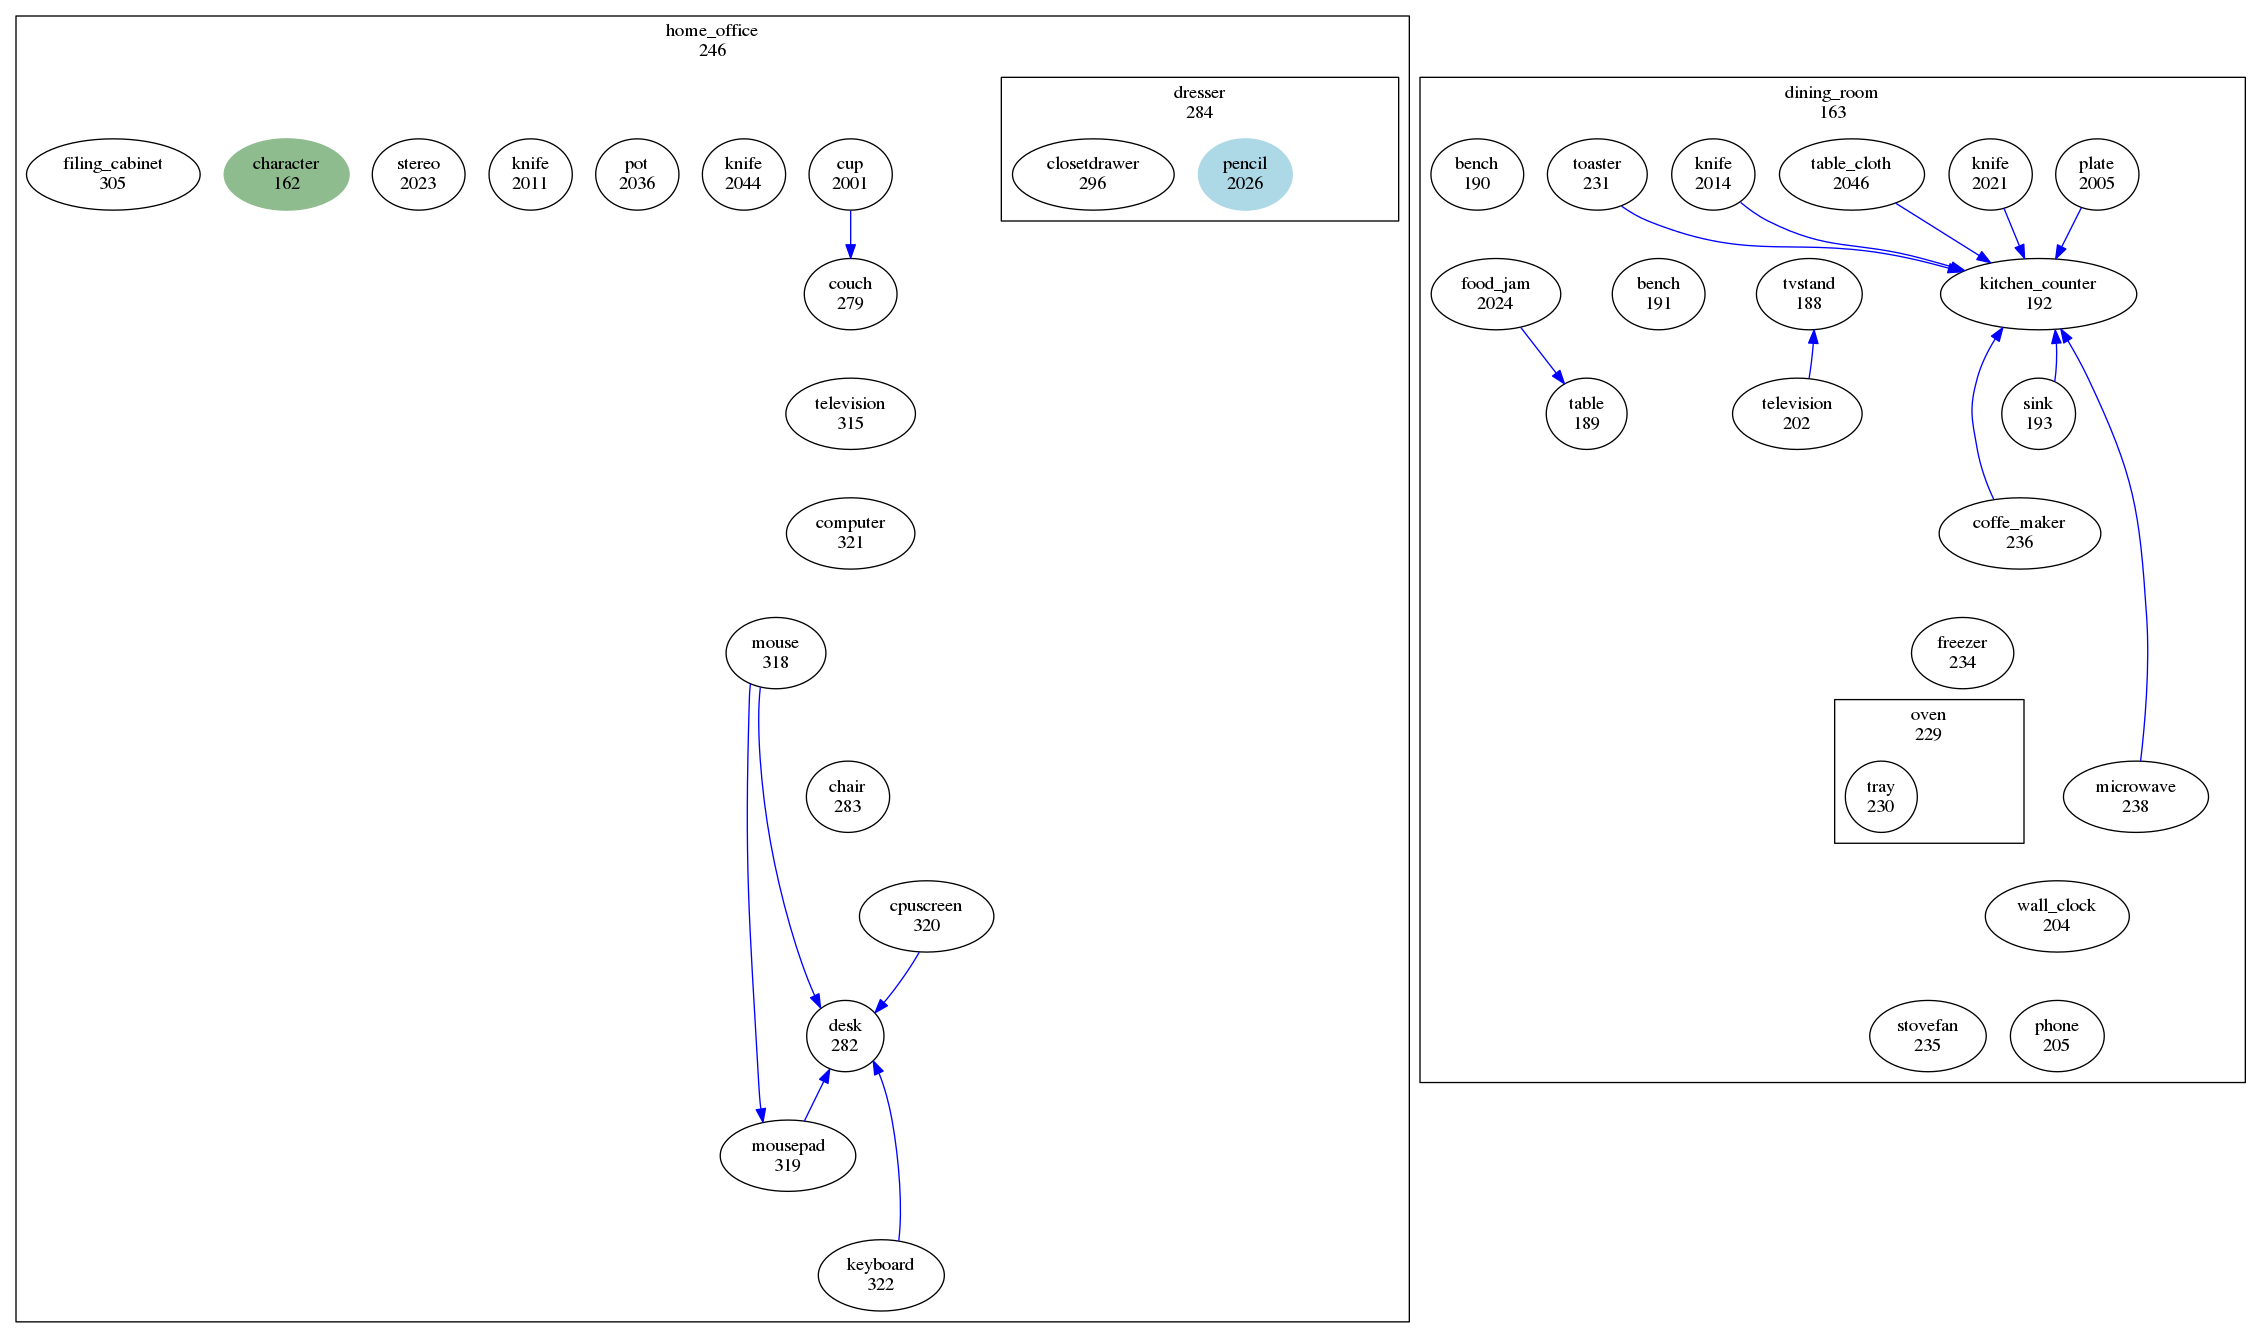

In [82]:
graph = utils_viz.graph2im(gt_state, {id_goal: 'goal', id_agent: 'agent'})
graph.format = 'png'
tmp = graph.view()
display(Image(tmp))

### Explore the model

Edges...


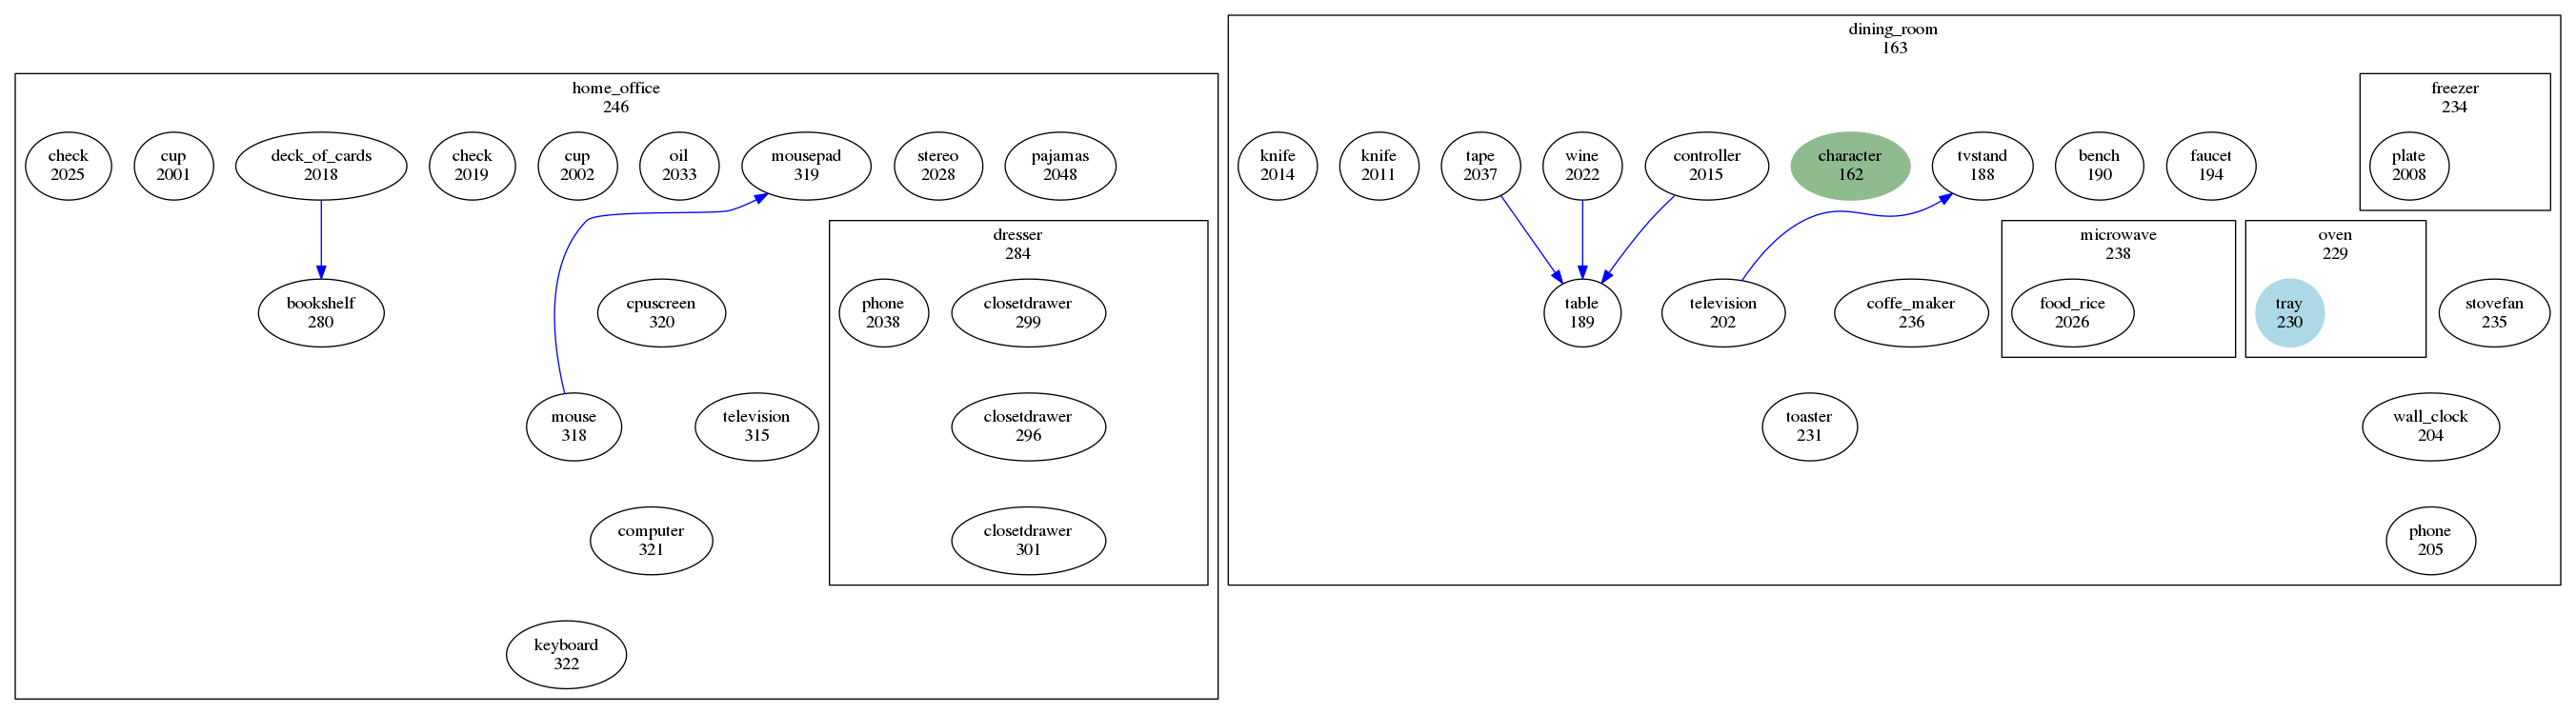

In [155]:
path_init_env = 'dataset_toy4/init_envs/TrimmedTestScene6_graph_35.json'

goal_name = {0:'(facing living_room[1] living_room[1])'}
curr_env.reset(path_init_env, goal_name)
curr_env.to_pomdp()
single_agent = SingleAgent(curr_env, goal_name, 0, dataset_interactive, policy_net)
gt_state = curr_env.vh_state.to_dict()
import json
with open('dataset_toy4/init_envs/TrimmedTestScene6_graph_35_multiple_5.json', 'r') as f:
    graph_multiple = json.load(f)
time = 0
gt_state = graph_multiple[time][1]

id_agent = [x['id'] for x in gt_state['nodes'] if x['class_name'] == 'character'][0]
id_goal = 230

goal_string = 'findnode_{}'.format(id_goal)
graph = utils_viz.graph2im(gt_state, {id_goal: 'goal', id_agent: 'agent'})
graph.format = 'png'
tmp = graph.view()
display(Image(tmp))


In [159]:
# POMDP
weights = 'logdir/dataset_folder.dataset_toy4_pomdp.True_graphsteps.3_training_mode.bc/2019-11-12_21.33.22.040142/chkpt/chkpt_149.pt'

single_agent.policy_net.load_state_dict(torch.load(weights)['model_params'])
curr_state = single_agent.get_observations()

id_char = [x['id'] for x in curr_state['nodes'] if x['class_name'] == 'character'][0]
curr_state['edges'].append({'relation_type': 'CLOSE', 'from_id':id_char ,'to_id': 229})
curr_state['edges'].append({'relation_type': 'CLOSE', 'from_id':id_char ,'to_id': 230})
#curr_state['edges'] = [x for x in curr_state['edges'] if x['relation_type'] != 'CLOSE' or (x['from_id'] == id_char or x['to_id'] == id_char)]



visible_ids = None
graph_data, action_logits, o1_logits, o2_logits = single_agent.obtain_logits_from_observations(curr_state, visible_ids, goal_string)
instruction = single_agent.get_top_instruction(dataset_interactive, graph_data, action_logits, o1_logits, o2_logits)
instr = list(zip(*instruction))[0]
str_instruction = utils.pretty_instr(instr)
print(str_instruction)


# FOMDP
weights = 'logdir/dataset_folder.dataset_toy4_pomdp.False_graphsteps.3_training_mode.bc/2019-11-12_21.33.57.388801/chkpt/chkpt_149.pt'

single_agent.policy_net.load_state_dict(torch.load(weights)['model_params'])
curr_state = single_agent.env.vh_state.to_dict()
#curr_state['edges'] = [x for x in curr_state['edges'] if x['relation_type'] != 'CLOSE']
#curr_state['edges'] = [x for x in curr_state['edges'] if x['relation_type'] != 'CLOSE' or (x['from_id'] == id_char 
#                       or x['to_id'] == id_char)]

curr_state['edges'].append({'relation_type': 'CLOSE', 'from_id':id_char ,'to_id': 229})
curr_state['edges'].append({'relation_type': 'CLOSE', 'from_id':id_char ,'to_id': 230})
curr_state['edges'].append({'relation_type': 'CLOSE', 'to_id':id_char ,'from_id': 229})
curr_state['edges'].append({'relation_type': 'CLOSE', 'to_id':id_char ,'from_id': 230})
visible_ids = single_agent.env.observable_object_ids_n[0]
graph_data, action_logits, o1_logits, o2_logits = single_agent.obtain_logits_from_observations(curr_state, visible_ids, goal_string)
instruction = single_agent.get_top_instruction(dataset_interactive, graph_data, action_logits, o1_logits, o2_logits)
instr = list(zip(*instruction))[0]
str_instruction = utils.pretty_instr(instr)
print(str_instruction)

[stop] <oven> (229) 
[open] <oven> (229) 


### Multiple step rollout

In [71]:
def one_step_rollout(env, goal_string, pomdp):
    if pomdp:
        curr_state = single_agent.get_observations()
        visible_ids = None
    else:
        curr_state = single_agent.env.vh_state.to_dict()
        visible_ids = single_agent.env.observable_object_ids_n[0]
    
    graph_data, action_logits, o1_logits, o2_logits = single_agent.obtain_logits_from_observations(curr_state, visible_ids, goal_string)
    instruction, logits = single_agent.sample_instruction(dataset_interactive, graph_data, 
                                                          action_logits, o1_logits, o2_logits, pick_max=True)
    #instruction = single_agent.get_top_instruction(dataset_interactive, graph_data, action_logits, o1_logits, o2_logits)
    logits = None
    instr = list(zip(*instruction))[0]
    str_instruction = utils.pretty_instr(instr)
    if 'stop' in str_instruction:
            return None, str_instruction, logits
    resp = single_agent.env.step({0: str_instruction})
    return resp, str_instruction, logits

In [72]:
args.pomdp = False
weights = 'logdir/dataset_folder.dataset_toy3_pomdp.False_graphsteps.3/2019-11-06_09.14.31.202175/chkpt/chkpt_49.pt'
state_dict = torch.load(weights)
single_agent.policy_net.load_state_dict(state_dict['model_params'])

curr_env.reset(path_init_env, goal_name)
max_instr = 0
instr = ''
goal_str = 'findnode_315'
while max_instr < 10 and 'stop' not in instr:
    a = one_step_rollout(single_agent.env, goal_str, args.pomdp)
    instr = a[1]
    max_instr += 1
    print(instr)

FileNotFoundError: [Errno 2] No such file or directory: 'logdir/dataset_folder.dataset_toy3_pomdp.False_graphsteps.3/2019-11-06_09.14.31.202175/chkpt/chkpt_49.pt'

In [73]:
curr_env.reset(path_init_env, goal_name)
max_instr = 0
instr = ''
goal_str = 'findnode_301'
while max_instr < 10 and 'stop' not in instr:
    a = one_step_rollout(single_agent.env, goal_str, args.pomdp)
    instr = a[1]
    max_instr += 1
    print(instr)

KeyError: 301

### Back to non POMDP

In [74]:
%autoreload 2

In [75]:

path_init_env = "dataset_toy3/init_envs/TrimmedTestScene6_graph_28.json"
goal_name = '(facing living_room[1] living_room[1])'
curr_env.reset(path_init_env, {0: goal_name})
curr_env.to_pomdp()
single_agent = SingleAgent(curr_env, goal_name, 0, dataset_interactive, policy_net)

# Starting the scene
curr_state = single_agent.get_observations()
gt_state = single_agent.env.vh_state.to_dict()

# All the nodes
nodes, _, ids_used = dataset_interactive.process_graph(gt_state)
class_names, object_ids, _, mask_nodes, _ = nodes

Edges...


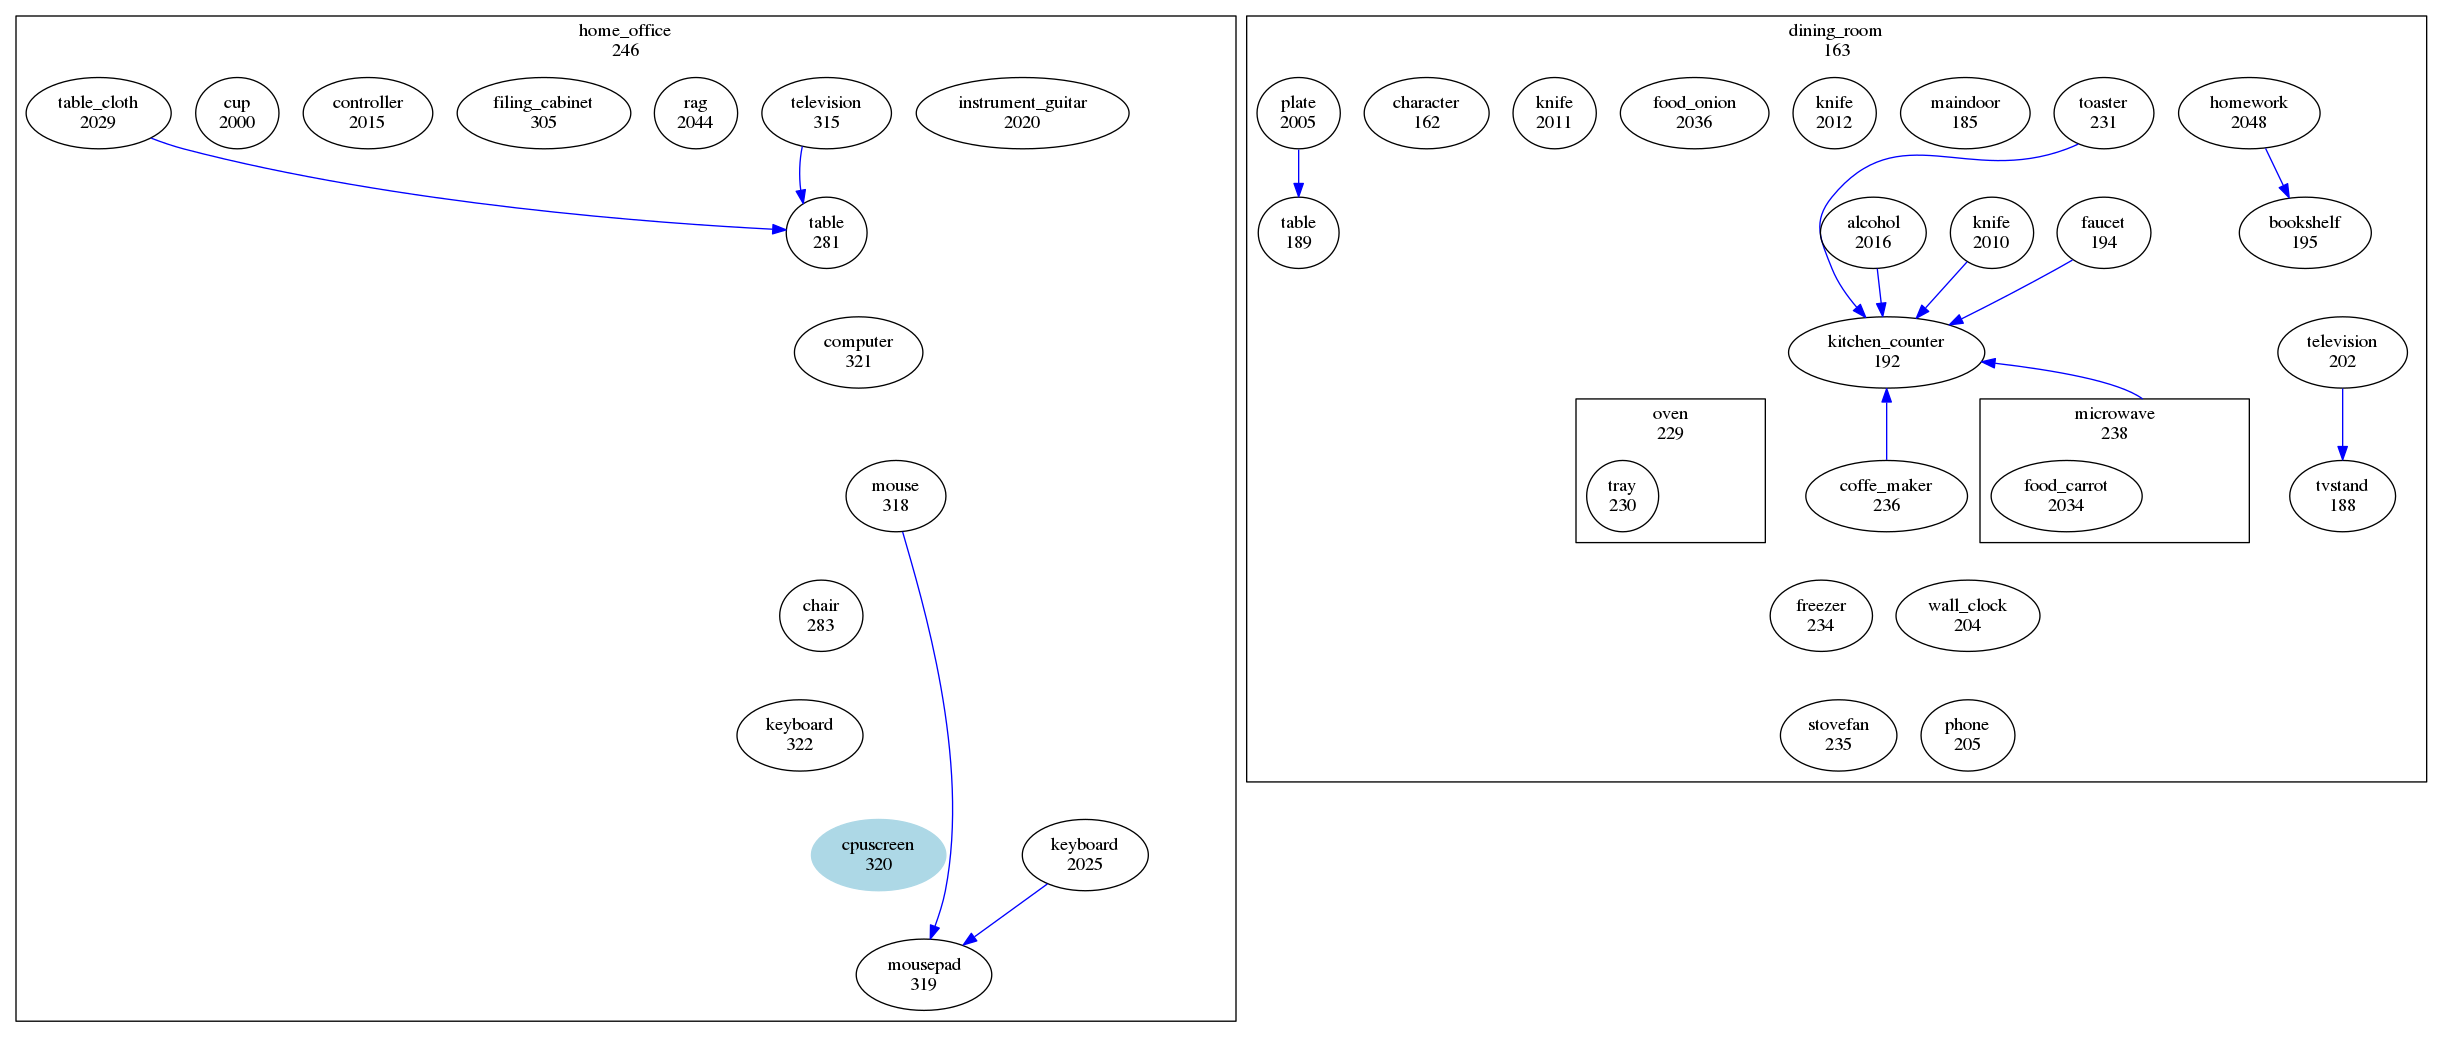

In [76]:
graph = utils_viz.graph2im(gt_state, {320: 'goal', id_agent: 'agent'})
graph.format = 'png'
tmp = graph.view()
display(Image(tmp))

In [145]:
args.pomdp = False
weights = 'logdir/dataset_folder.dataset_toy3_pomdp.False_graphsteps.3/2019-11-06_09.14.31.202175/chkpt/chkpt_49.pt'
state_dict = torch.load(weights)
single_agent.policy_net.load_state_dict(state_dict['model_params'])
curr_env.reset(path_init_env, {0:goal_name})
max_instr = 0
instr = ''
goal_str = 'findnode_320'
while max_instr < 10 and 'stop' not in instr:
    a = one_step_rollout(single_agent.env, goal_str, args.pomdp)
    instr = a[1]
    max_instr += 1
    print(instr)

Loading graph...
Loaded
[walk] <homework> (2048) 
[walk] <dining_room> (163) 
[walk] <homework> (2048) 
[walk] <dining_room> (163) 
[walk] <homework> (2048) 
[walk] <dining_room> (163) 
[walk] <homework> (2048) 
[walk] <dining_room> (163) 
[walk] <homework> (2048) 
[walk] <dining_room> (163) 


In [146]:
args.pomdp = True
weights = 'logdir/dataset_folder.dataset_toy3_pomdp.True_graphsteps.3/2019-11-06_09.13.35.555005/chkpt/chkpt_49.pt'
state_dict = torch.load(weights)
single_agent.policy_net.load_state_dict(state_dict['model_params'])
curr_env.reset(path_init_env, {0:goal_name})
max_instr = 0
instr = ''
goal_str = 'findnode_320'
while max_instr < 10 and 'stop' not in instr:
    a = one_step_rollout(single_agent.env, goal_str, args.pomdp)
    instr = a[1]
    max_instr += 1
    print(instr)

Loading graph...
Loaded
[walk] <home_office> (246) 
[walk] <cpuscreen> (320) 
[stop]  


In [14]:
%load_ext autoreload

In [15]:
%autoreload 2